In [1]:
import h5py
import numpy as np
import os
import torch
from torch.utils.data import DataLoader
import wandb
import pickle
from tqdm import tqdm
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from data_loader import get_loader
from model import CelebA_EBM
from utils import *

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Args:
    batch_size = 128
    lr = 1e-3
    image_dir = '/mnt/data/10708-controllable-generation/data/celeba/img_align_celeba'
    attr_fp = '/mnt/data/10708-controllable-generation/data/celeba/list_attr_celeba.txt'
    seed = 208975
    num_workers = 2
    use_wandb = False
    n_epochs = 7

In [10]:
def denorm(x):
    """Convert the range from [-1, 1] to [0, 1]."""
    out = (x + 1) / 2
    return out.clamp_(0, 1)

In [3]:
args = Args()
set_seed(args.seed)
    
train_loader = get_loader(args.image_dir, 
                       args.attr_fp, 
                       ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young'],
                       178, 128, 32,
                       'CelebA', 'train', 2)
val_loader = get_loader(args.image_dir, 
                       args.attr_fp, 
                       ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young'],
                       178, 128, 32,
                       'CelebA', 'train', 2)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torch.load('model.pth').to(device)

Finished preprocessing the CelebA dataset...
Finished preprocessing the CelebA dataset...


In [4]:
_ = model.eval()

In [6]:
for images, labels in tqdm(train_loader):
    images, labels = images.to(device), labels[:, -2].to(device)
    
    with torch.no_grad():
        correct_out = model(images, labels)
        wrong_out = model(images, 1 - labels)
    loss = (wrong_out + 1).square().mean() + (correct_out - 1).square().mean()

    break

  0%|                                                                                          | 0/6269 [00:00<?, ?it/s]


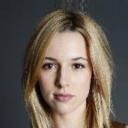

In [16]:
transforms.ToPILImage()(denorm(images[0]))

In [50]:
model(images[:1], 1- labels[:1])

tensor([[-0.9661]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [45]:
def langevin(image, label, model, alpha=0.1, max_steps=1000, std=0.0002):
    
    label.requires_grad = True
    orig_image = image.clone()
    
    for i in range(max_steps):
        
        image.requires_grad = True
        energy = model(image.unsqueeze(0), label.unsqueeze(0).clone())
        energy = (energy - 1).square()
        print(energy.item())
        model.zero_grad()
        energy.backward()
        image_grad = image.grad
        image = image.detach() - image_grad.detach()*alpha + torch.randn(1).cuda()*std
        
    return image

In [46]:
image = langevin(images[0].clone(), torch.tensor(1.).cuda(), model)

3.865354061126709
3.848489284515381
3.8325319290161133
3.8173892498016357
3.803361654281616
3.7895028591156006
3.7760071754455566
3.761098861694336
3.7465171813964844
3.7334818840026855
3.7253246307373047
3.7166764736175537
3.7072689533233643
3.699519634246826
3.6922767162323
3.684162139892578
3.678375005722046
3.672774314880371
3.6678466796875
3.6636223793029785
3.6575796604156494
3.6545395851135254
3.649669647216797
3.646416187286377
3.6421403884887695
3.639465093612671
3.635988712310791
3.631582021713257
3.6286044120788574
3.6248466968536377
3.6213576793670654
3.6182422637939453
3.614169120788574
3.6125588417053223
3.608006477355957
3.60518479347229
3.602271795272827
3.5980725288391113
3.5968542098999023
3.5945398807525635
3.5897469520568848
3.5859458446502686
3.5847041606903076
3.5805323123931885
3.577346086502075
3.5750155448913574
3.5737979412078857
3.5700509548187256
3.5672659873962402
3.565667152404785
3.5627989768981934
3.560051202774048
3.5574588775634766
3.5549378395080566
3

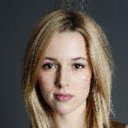

In [47]:
transforms.ToPILImage()(denorm(image))

In [48]:
model(image.unsqueeze(0), torch.tensor(1).to(device).unsqueeze(0))

tensor([[0.9983]], device='cuda:0', grad_fn=<AddmmBackward0>)